# Ejercicio Scoring - Inferencia de Rechazados

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Para elálisis descriptivo inicial de contraste de asociación
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway


# Librería para hacer la tramificación, agrupación y transformación WOE
from optbinning import Scorecard, BinningProcess, OptimalBinning
from optbinning.scorecard import plot_auc_roc, plot_cap, plot_ks


# Scikit-learn para dividir la muestra y para estimar el modelo de regresión logística
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

(CVXPY) Mar 25 08:51:56 AM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.5.2237). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Mar 25 08:51:56 AM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.5.2237). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


In [2]:
df = pd.read_excel('DatosPractica_Scoring.xlsx', index_col=0)
df.head()

,Cardhldr,default,Age,Income,Exp_Inc,Avgexp,Ownrent,Selfempl,Depndt,Inc_per,Cur_add,Major,Active
ID,,,,,,,,,,,,,
1,1.0,0.0,27.08333,2.400,0.016798,33.01333,0,0,0,2.400000,56,1,1
2,1.0,1.0,24.25000,3.500,0.069963,203.89170,0,0,0,3.500000,60,1,11
3,0.0,NaN,27.41667,1.600,0.000750,0.00000,1,0,1,0.800000,30,0,0
4,1.0,0.0,40.33333,3.067,0.159700,408.08250,0,0,2,1.022333,18,0,0
5,1.0,0.0,28.16667,3.350,0.071625,199.36920,1,0,0,3.350000,18,1,2


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1319 entries, 1 to 1319
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Cardhldr  1285 non-null   float64
 1   default   994 non-null    float64
 2   Age       1319 non-null   float64
 3   Income    1319 non-null   float64
 4   Exp_Inc   1319 non-null   float64
 5   Avgexp    1319 non-null   float64
 6   Ownrent   1319 non-null   int64  
 7   Selfempl  1319 non-null   int64  
 8   Depndt    1319 non-null   int64  
 9   Inc_per   1319 non-null   float64
 10  Cur_add   1319 non-null   int64  
 11  Major     1319 non-null   int64  
 12  Active    1319 non-null   int64  
dtypes: float64(7), int64(6)
memory usage: 144.3 KB


In [4]:
df['income_log'] = np.log(df.Income)

In [5]:
nuevos = df.loc[df.Cardhldr.isnull() == True].reset_index()
nuevos

,ID,Cardhldr,default,Age,Income,Exp_Inc,Avgexp,Ownrent,Selfempl,Depndt,Inc_per,Cur_add,Major,Active,income_log
0,1286,NaN,NaN,27.00000,2.6750,0.034820,77.286670,1,0,0,2.675000,135,1,0,0.983949
1,1287,NaN,NaN,27.58333,5.5000,0.220473,1010.502000,0,1,0,5.500000,72,1,11,1.704748
2,1288,NaN,NaN,31.25000,5.0000,0.074378,309.910000,1,0,2,1.666667,12,1,12,1.609438
3,1289,NaN,NaN,25.25000,2.8800,0.041061,98.464160,0,0,0,2.880000,7,1,0,1.057790
4,1290,NaN,NaN,30.00000,1.8500,0.107582,165.855000,0,0,0,1.850000,60,1,12,0.615186
5,1291,NaN,NaN,35.50000,5.5000,0.012896,58.608330,0,0,0,5.500000,36,1,2,1.704748
6,1292,NaN,NaN,33.25000,3.6000,0.025991,77.806660,0,0,3,0.900000,16,1,9,1.280934
7,1293,NaN,NaN,39.00000,3.5000,0.045145,131.674200,1,0,2,1.166667,113,0,13,1.252763
8,1294,NaN,NaN,40.75000,8.0000,0.046671,311.142500,1,0,2,2.666667,38,1,0,2.079442
9,1295,NaN,NaN,63.16667,5.5000,0.020482,93.625000,1,0,1,2.750000,192,1,15,1.704748


In [6]:
aceptados = df.loc[df.Cardhldr == 1].reset_index()
rechazados = df.loc[df.Cardhldr == 0].reset_index()
aceptados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 994 entries, 0 to 993
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          994 non-null    int64  
 1   Cardhldr    994 non-null    float64
 2   default     994 non-null    float64
 3   Age         994 non-null    float64
 4   Income      994 non-null    float64
 5   Exp_Inc     994 non-null    float64
 6   Avgexp      994 non-null    float64
 7   Ownrent     994 non-null    int64  
 8   Selfempl    994 non-null    int64  
 9   Depndt      994 non-null    int64  
 10  Inc_per     994 non-null    float64
 11  Cur_add     994 non-null    int64  
 12  Major       994 non-null    int64  
 13  Active      994 non-null    int64  
 14  income_log  994 non-null    float64
dtypes: float64(8), int64(7)
memory usage: 116.6 KB


In [7]:
aceptados.nunique()

ID            994
Cardhldr        1
default         2
Age           378
Income        343
Exp_Inc       990
Avgexp        955
Ownrent         2
Selfempl        2
Depndt          7
Inc_per       424
Cur_add       177
Major           2
Active         31
income_log    343
dtype: int64

In [8]:
aceptados.default.value_counts(normalize=True)

0.0    0.895372
1.0    0.104628
Name: default, dtype: float64

In [9]:
to_factor = list(aceptados.loc[:, aceptados.nunique() <= 2])
aceptados[to_factor] = aceptados[to_factor].astype('category')
aceptados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 994 entries, 0 to 993
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ID          994 non-null    int64   
 1   Cardhldr    994 non-null    category
 2   default     994 non-null    category
 3   Age         994 non-null    float64 
 4   Income      994 non-null    float64 
 5   Exp_Inc     994 non-null    float64 
 6   Avgexp      994 non-null    float64 
 7   Ownrent     994 non-null    category
 8   Selfempl    994 non-null    category
 9   Depndt      994 non-null    int64   
 10  Inc_per     994 non-null    float64 
 11  Cur_add     994 non-null    int64   
 12  Major       994 non-null    category
 13  Active      994 non-null    int64   
 14  income_log  994 non-null    float64 
dtypes: category(5), float64(6), int64(4)
memory usage: 83.2 KB


In [10]:
aceptados.Major.value_counts()

1    836
0    158
Name: Major, dtype: int64

In [11]:
#dt_train, dt_test = train_test_split(aceptados,stratify=aceptados["Cardhldr"], test_size=.25, random_state=1234)

In [12]:
Y = aceptados['default'].values
X = aceptados.drop(columns=['Cardhldr', 'default', 'ID']) #todas menos la primera que es el ID y la variable y
list_variables = X.columns.values.tolist()
list_categorical = X.select_dtypes(include=['category']).columns.values.tolist()

In [13]:
selection_criteria = {
    "iv": {"min": 0.02, "max": 1}
}

In [14]:
# 3) Definimos el proceso de Tramificación o BinningProcess
binning_process = BinningProcess(
    categorical_variables=list_categorical,
    variable_names=list_variables,
    selection_criteria=selection_criteria)

In [15]:
# 4) Obtenemos los tramos optimos de todas las Variables
df_binned = binning_process.fit(X, Y)

In [16]:
df_binned.summary().sort_values('iv')

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
6,Depndt,numerical,OPTIMAL,False,4,0.005121,0.00064,0.035048,0.000135
5,Selfempl,categorical,OPTIMAL,False,2,0.011895,0.001478,0.028111,0.005643
4,Ownrent,categorical,OPTIMAL,False,2,0.011976,0.001496,0.054689,0.02354
9,Major,categorical,OPTIMAL,True,2,0.030557,0.003792,0.059399,0.039958
7,Inc_per,numerical,OPTIMAL,True,7,0.15624,0.018334,0.183395,0.025607
2,Exp_Inc,numerical,OPTIMAL,True,5,0.187134,0.02197,0.191595,0.194671
8,Cur_add,numerical,OPTIMAL,True,6,0.192857,0.023537,0.232347,0.002619
1,Income,numerical,OPTIMAL,True,5,0.222999,0.026768,0.215741,0.055953
11,income_log,numerical,OPTIMAL,True,5,0.222999,0.026768,0.215741,0.055953
0,Age,numerical,OPTIMAL,True,7,0.224977,0.026616,0.236603,0.021707


# Proceso completo para modelo

In [17]:
aceptados.nunique()

ID            994
Cardhldr        1
default         2
Age           378
Income        343
Exp_Inc       990
Avgexp        955
Ownrent         2
Selfempl        2
Depndt          7
Inc_per       424
Cur_add       177
Major           2
Active         31
income_log    343
dtype: int64

In [18]:
aceptados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 994 entries, 0 to 993
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ID          994 non-null    int64   
 1   Cardhldr    994 non-null    category
 2   default     994 non-null    category
 3   Age         994 non-null    float64 
 4   Income      994 non-null    float64 
 5   Exp_Inc     994 non-null    float64 
 6   Avgexp      994 non-null    float64 
 7   Ownrent     994 non-null    category
 8   Selfempl    994 non-null    category
 9   Depndt      994 non-null    int64   
 10  Inc_per     994 non-null    float64 
 11  Cur_add     994 non-null    int64   
 12  Major       994 non-null    category
 13  Active      994 non-null    int64   
 14  income_log  994 non-null    float64 
dtypes: category(5), float64(6), int64(4)
memory usage: 83.2 KB


In [19]:
ctabla=pd.crosstab(aceptados['Ownrent'],aceptados['default'],margins=True).round(3)
ctabla

default,0.0,1.0,All
Ownrent,,,
0,468,49,517
1,422,55,477
All,890,104,994


In [20]:
c, p, dof, expected = chi2_contingency(ctabla) 
# Print the p-value
print(p)

0.8917523862803937


No se puede rechazar la Hipotesisi Nula por lo que podemos concluir que existe independencia entre la variable Ownrent y la var impago.

In [21]:
ctabla=pd.crosstab(aceptados['Selfempl'],aceptados['default'],margins=True).round(3)
ctabla

default,0.0,1.0,All
Selfempl,,,
0,838,95,933
1,52,9,61
All,890,104,994


In [22]:
c, p, dof, expected = chi2_contingency(ctabla) 
# Print the p-value
print(p)

0.8651786641433323


Se observa independencia para la variable Selfempl igualmente.

In [23]:
ctabla=pd.crosstab(aceptados['Major'],aceptados['default'],margins=True).round(3)
ctabla

default,0.0,1.0,All
Major,,,
0,147,11,158
1,743,93,836
All,890,104,994


In [24]:
c, p, dof, expected = chi2_contingency(ctabla) 
# Print the p-value
print(p)

0.6522460095330043


In [25]:
ctabla=pd.crosstab(aceptados['Depndt'],aceptados['default'],margins=True).round(3)
ctabla

default,0.0,1.0,All
Depndt,,,
0,453,53,506
1,185,21,206
2,134,14,148
3,75,12,87
4,33,2,35
5,6,1,7
6,4,1,5
All,890,104,994


In [26]:
c, p, dof, expected = chi2_contingency(ctabla) 
# Print the p-value
print(p)

0.9995564935521011


Esa variable debe ser modificada en cuanto a nivels se refiere, ya que vemos poca incidencia en los valores mas altos.

In [27]:
aceptados.describe()

,ID,Age,Income,Exp_Inc,Avgexp,Depndt,Inc_per,Cur_add,Active,income_log
count,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000,994.000000
mean,643.062374,33.188715,3.447242,0.089110,239.612725,0.973843,2.214605,54.691147,7.265594,1.139148
std,366.554739,10.180138,1.716888,0.099877,289.158901,1.250708,1.355279,64.671143,6.074552,0.430325
min,1.000000,0.166667,0.210000,0.000186,0.000000,0.000000,0.070000,0.000000,0.000000,-1.560648
25%,332.250000,25.333330,2.313625,0.026912,66.823750,0.000000,1.250000,12.000000,2.000000,0.838814
50%,646.500000,31.000000,3.000000,0.060319,150.540850,0.000000,1.970667,28.000000,6.000000,1.098612
75%,957.750000,39.729168,4.000000,0.114712,315.023975,2.000000,2.797500,72.000000,11.000000,1.386294
max,1285.000000,83.500000,13.500000,0.906320,3099.505000,6.000000,10.999900,540.000000,31.000000,2.602690


In [28]:
edades_erroneas = aceptados.loc[aceptados.Age < 18]
aceptados.loc[aceptados.Age  < 18] =np.nan
aceptados.dropna()
aceptados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 994 entries, 0 to 993
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ID          989 non-null    float64 
 1   Cardhldr    989 non-null    category
 2   default     989 non-null    category
 3   Age         989 non-null    float64 
 4   Income      989 non-null    float64 
 5   Exp_Inc     989 non-null    float64 
 6   Avgexp      989 non-null    float64 
 7   Ownrent     989 non-null    category
 8   Selfempl    989 non-null    category
 9   Depndt      989 non-null    float64 
 10  Inc_per     989 non-null    float64 
 11  Cur_add     989 non-null    float64 
 12  Major       989 non-null    category
 13  Active      989 non-null    float64 
 14  income_log  989 non-null    float64 
dtypes: category(5), float64(10)
memory usage: 83.2 KB


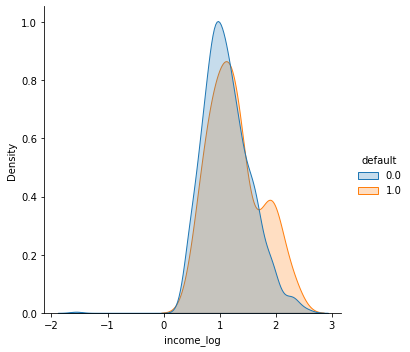

In [29]:

sns.displot(x=(aceptados['income_log']), kind="kde",hue=aceptados.default, common_norm=False, fill=True)
plt.show()

In [30]:
display(aceptados.sort_values('income_log').head())

,ID,Cardhldr,default,Age,Income,Exp_Inc,Avgexp,Ownrent,Selfempl,Depndt,Inc_per,Cur_add,Major,Active,income_log
865,1117.0,1.0,0.0,49.83333,0.21,0.271857,47.24166,1,0,2.0,0.07,42.0,1,1.0,-1.560648
749,962.0,1.0,0.0,32.83333,1.32,0.038755,42.63083,0,0,1.0,0.66,6.0,1,2.0,0.277632
965,1245.0,1.0,0.0,20.16667,1.50,0.119641,149.55080,0,0,0.0,1.50,3.0,1,3.0,0.405465
591,756.0,1.0,0.0,54.41667,1.50,0.016611,20.18083,0,0,0.0,1.50,24.0,0,1.0,0.405465
425,558.0,1.0,0.0,30.41667,1.50,0.063441,78.88500,0,0,1.0,0.75,24.0,0,5.0,0.405465


In [31]:
fvalue, pvalue = f_oneway(aceptados.loc[aceptados["default"]==0,['Income']], aceptados.loc[aceptados["default"]==1,['Income']])
print(f'F value: {fvalue}, Pvalue: {pvalue}')

F value: [11.89945049], Pvalue: [0.00058525]


In [32]:
fvalue, pvalue = f_oneway(aceptados.loc[aceptados["default"]==0,['income_log']], aceptados.loc[aceptados["default"]==1,['income_log']])
print(f'F value: {fvalue}, Pvalue: {pvalue}')

F value: [11.01815462], Pvalue: [0.00093525]


In [33]:
no_avg = aceptados.loc[aceptados.Avgexp.round(5) == 0]
aceptados.loc[aceptados.Avgexp.round(5) == 0] = np.nan
aceptados.dropna()
aceptados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 994 entries, 0 to 993
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ID          968 non-null    float64 
 1   Cardhldr    968 non-null    category
 2   default     968 non-null    category
 3   Age         968 non-null    float64 
 4   Income      968 non-null    float64 
 5   Exp_Inc     968 non-null    float64 
 6   Avgexp      968 non-null    float64 
 7   Ownrent     968 non-null    category
 8   Selfempl    968 non-null    category
 9   Depndt      968 non-null    float64 
 10  Inc_per     968 non-null    float64 
 11  Cur_add     968 non-null    float64 
 12  Major       968 non-null    category
 13  Active      968 non-null    float64 
 14  income_log  968 non-null    float64 
dtypes: category(5), float64(10)
memory usage: 83.2 KB


C:\Users\guill\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[]

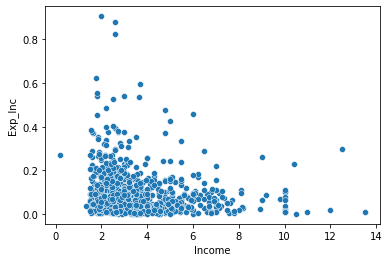

In [34]:
#plt.clf()
sns.scatterplot(aceptados.Income, aceptados.Exp_Inc)
plt.plot()
#aceptados.columns

In [35]:
fvalue, pvalue = f_oneway(aceptados.loc[aceptados["default"]==0,['Avgexp']], aceptados.loc[aceptados["default"]==1,['Avgexp']])
print(f'F value: {fvalue}, Pvalue: {pvalue}')



F value: [9.30205052], Pvalue: [0.0023514]


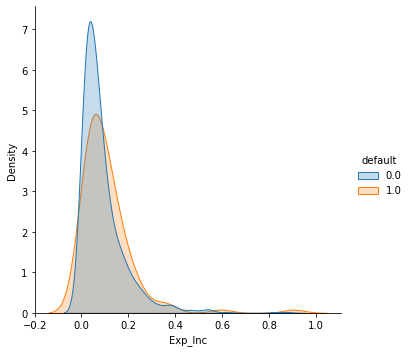

In [36]:
sns.displot(x=(aceptados['Exp_Inc']), kind="kde", hue=aceptados.default, common_norm=False, fill=True)
plt.show()

In [37]:
fvalue, pvalue = f_oneway(aceptados.loc[aceptados["default"]==0,['Exp_Inc']], aceptados.loc[aceptados["default"]==1,['Exp_Inc']])
print(f'F value: {fvalue}, Pvalue: {pvalue}')

F value: [3.07960267], Pvalue: [0.07959689]


NO SIGNIFICATIVA

In [38]:
aceptados.dropna(inplace=True)
aceptados.reset_index()
aceptados.default = aceptados.default.astype('int64')
aceptados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 968 entries, 0 to 993
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ID          968 non-null    float64 
 1   Cardhldr    968 non-null    category
 2   default     968 non-null    int64   
 3   Age         968 non-null    float64 
 4   Income      968 non-null    float64 
 5   Exp_Inc     968 non-null    float64 
 6   Avgexp      968 non-null    float64 
 7   Ownrent     968 non-null    category
 8   Selfempl    968 non-null    category
 9   Depndt      968 non-null    float64 
 10  Inc_per     968 non-null    float64 
 11  Cur_add     968 non-null    float64 
 12  Major       968 non-null    category
 13  Active      968 non-null    float64 
 14  income_log  968 non-null    float64 
dtypes: category(4), float64(10), int64(1)
memory usage: 95.0 KB


In [39]:
aceptados_train, aceptados_test = train_test_split(aceptados,stratify=aceptados["default"], test_size=.25, random_state=1234)

In [40]:
aceptados_train["default"].mean()

0.10606060606060606

In [41]:
aceptados_test["default"].mean()

0.10743801652892562

In [42]:
# 1) Definimos la lista de nombres señalando cualse de ellas son las categóricas
Y = aceptados_train['default'].values
X = aceptados_train.drop(columns=['default', 'Cardhldr', 'ID', 'Exp_Inc', 'Avgexp', 'Income', 'Inc_per']) #todas menos la primera que es el ID y la variable y
list_variables = X.columns.values.tolist()
list_categorical = X.select_dtypes(include=['object', 'category']).columns.values.tolist()

In [43]:
# 2) Definimos el criterio de selección
selection_criteria = {
    "iv": {"min": 0.018, "max": 1}}

In [44]:
# 3) Definimos el proceso de Tramificación o BinningProcess
binning_process = BinningProcess(
    categorical_variables=list_categorical,
    variable_names=list_variables,
    selection_criteria=selection_criteria)

In [45]:
# 4) Obtenemos los tramos optimos de todas las Variables
dt_train_binned = binning_process.fit(X, Y)

In [46]:
dt_train_binned.summary().sort_values('iv')

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
2,Selfempl,categorical,OPTIMAL,False,2,0.001098,0.000137,0.007924,0.000147
1,Ownrent,categorical,OPTIMAL,False,2,0.015227,0.001902,0.061633,0.029303
5,Major,categorical,OPTIMAL,True,2,0.01954,0.002433,0.050407,0.022814
3,Depndt,numerical,OPTIMAL,True,3,0.024996,0.003112,0.070818,0.026221
0,Age,numerical,OPTIMAL,True,7,0.202133,0.023758,0.211514,0.011113
4,Cur_add,numerical,OPTIMAL,True,6,0.229538,0.027484,0.24025,0.121117
7,income_log,numerical,OPTIMAL,True,6,0.233139,0.027579,0.220859,0.006723
6,Active,numerical,OPTIMAL,True,6,0.871375,0.092359,0.412223,0.00384


In [47]:
dt_train_binned.get_binned_variable("Active").binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 2.50)",195,0.268595,193,2,0.010256,2.437916,0.661666,0.066867
1,"[2.50, 6.50)",185,0.254821,167,18,0.097297,0.095995,0.002261,0.000283
2,"[6.50, 9.50)",120,0.165289,105,15,0.125000,-0.185717,0.006132,0.000765
3,"[9.50, 11.50)",62,0.085399,54,8,0.129032,-0.222085,0.004595,0.000573
4,"[11.50, 18.50)",119,0.163912,96,23,0.193277,-0.702773,0.105965,0.012980
5,"[18.50, inf)",45,0.061983,34,11,0.244444,-1.003162,0.090755,0.010891
6,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
7,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,726,1.000000,649,77,0.106061,,0.871375,0.092359


In [48]:
dt_train_binned.get_binned_variable("Major").binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[0],127,0.174931,117,10,0.078740,0.327962,0.016532,0.002057
1,[1],599,0.825069,532,67,0.111853,-0.059676,0.003008,0.000376
2,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
3,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,726,1.000000,649,77,0.106061,,0.019540,0.002433


In [49]:
dt_train_binned.information()

optbinning (Version 0.17.3)
Copyright (c) 2019-2022 Guillermo Navas-Palencia, Apache License 2.0

  Statistics
    Number of records                    726
    Number of variables                    8
    Target type                       binary

    Number of numerical                    5
    Number of categorical                  3
    Number of selected                     6

  Time                                0.9987 sec



In [50]:
dt_train_woe=dt_train_binned.transform(X, metric="woe")
dt_train_woe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 726 entries, 0 to 725
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         726 non-null    float64
 1   Depndt      726 non-null    float64
 2   Cur_add     726 non-null    float64
 3   Major       726 non-null    float64
 4   Active      726 non-null    float64
 5   income_log  726 non-null    float64
dtypes: float64(6)
memory usage: 34.2 KB


In [51]:
dt_train_woe

,Age,Depndt,Cur_add,Major,Active,income_log
0,0.440291,0.004228,1.394733,-0.059676,2.437916,1.479291
1,-0.236233,0.004228,0.563000,-0.059676,0.095995,-0.066714
2,0.440291,0.004228,0.306759,0.327962,0.095995,-0.025752
3,0.440291,0.004228,0.563000,-0.059676,0.095995,0.348884
4,1.697014,0.004228,-0.043887,-0.059676,-0.185717,-0.025752
...,...,...,...,...,...,...
721,-0.236233,0.004228,-0.043887,-0.059676,-0.702773,0.348884
722,0.043124,0.004228,-0.275329,-0.059676,2.437916,0.348884
723,-0.023198,-0.289857,-0.275329,-0.059676,0.095995,-0.066714
724,-0.236233,0.321531,-0.043887,-0.059676,-0.222085,-0.025752


In [52]:
# Ahora aplicaríamos la misma transformación pero al conjunto de test (si hubiera que puntuar a nuevos clientes haríamos lo mismo)

Y_test = aceptados_test['default'].values
X_test = aceptados_test.drop(columns=['default', 'Cardhldr', 'ID', 'Exp_Inc', 'Avgexp', 'Income']) #todas menos la primera que es el ID y la variable y

dt_test_woe=dt_train_binned.transform(X_test, metric="woe")
dt_test_woe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242 entries, 0 to 241
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         242 non-null    float64
 1   Depndt      242 non-null    float64
 2   Cur_add     242 non-null    float64
 3   Major       242 non-null    float64
 4   Active      242 non-null    float64
 5   income_log  242 non-null    float64
dtypes: float64(6)
memory usage: 11.5 KB


In [53]:
# Directamente con el método Scorecard
estimator = LogisticRegression(solver="lbfgs")

# Establecemos los parámetros para la transformación de probabilidades en puntos de calidad crediticia o score

pdo_0 =40
scorecard_points_0= 600 
odds_0_B= 50 # (equivalente a  odds_0 =1/50 )

tarjeta= Scorecard(binning_process=binning_process,
                   estimator=estimator,
                   scaling_method="pdo_odds",
                   scaling_method_params={"pdo":pdo_0, "odds": odds_0_B, "scorecard_points": scorecard_points_0})

tarjeta.fit(X, Y, show_digits=4)

Scorecard(binning_process=BinningProcess(categorical_variables=['Ownrent',
                                                                'Selfempl',
                                                                'Major'],
                                         selection_criteria={'iv': {'max': 1,
                                                                    'min': 0.018}},
                                         variable_names=['Age', 'Ownrent',
                                                         'Selfempl', 'Depndt',
                                                         'Cur_add', 'Major',
                                                         'Active',
                                                         'income_log']),
          estimator=LogisticRegression(), scaling_method='pdo_odds',
          scaling_method_params={'odds': 50, 'pdo': 40,
                                 'scorecard_points': 600})

In [54]:
tarjeta.information(print_level=2)

optbinning (Version 0.17.3)
Copyright (c) 2019-2022 Guillermo Navas-Palencia, Apache License 2.0

  Begin options
    binning_process                      yes   * U
    estimator                            yes   * U
    scaling_method                  pdo_odds   * U
    scaling_method_params                yes   * U
    intercept_based                    False   * d
    reverse_scorecard                  False   * d
    rounding                           False   * d
    verbose                            False   * d
  End options

  Statistics
    Number of records                    726
    Number of variables                    8
    Target type                       binary

    Number of numerical                    5
    Number of categorical                  3
    Number of selected                     6

  Timing
    Total time                          1.21 sec
    Binning process                     1.17 sec   ( 96.26%)
    Estimator                           0.01 sec   (  1.22%

In [55]:
tarjeta.table(style="detailed")

,Variable,Bin id,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Coefficient,Points
0,Age,0,"(-inf, 21.9583)",49,0.067493,44,5,0.102041,0.043124,0.000123,0.000015,-0.397098,83.639841
1,Age,1,"[21.9583, 26.0417)",155,0.213499,144,11,0.070968,0.440291,0.034793,0.004314,-0.397098,92.741170
2,Age,2,"[26.0417, 27.6667)",47,0.064738,46,1,0.021277,1.697014,0.098242,0.010991,-0.397098,121.539819
3,Age,3,"[27.6667, 29.3750)",59,0.081267,53,6,0.101695,0.046905,0.000176,0.000022,-0.397098,83.726478
4,Age,4,"[29.3750, 36.0833)",157,0.216253,140,17,0.108280,-0.023198,0.000117,0.000015,-0.397098,82.120013
5,Age,5,"[36.0833, 52.0417)",222,0.305785,193,29,0.130631,-0.236233,0.018720,0.002335,-0.397098,77.238181
6,Age,6,"[52.0417, inf)",37,0.050964,29,8,0.216216,-0.843773,0.049961,0.006066,-0.397098,63.315998
7,Age,7,Special,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,-0.397098,82.651616
8,Age,8,Missing,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,-0.397098,82.651616
0,Depndt,0,"(-inf, 1.5000)",530,0.730028,474,56,0.105660,0.004228,0.000013,0.000002,-0.238569,82.709828


In [56]:
# obtenmos las predicciones
Y_pred=tarjeta.predict_proba(X)[:,1]

# Calculamos la media
Y_pred.mean().round(5)

0.10606

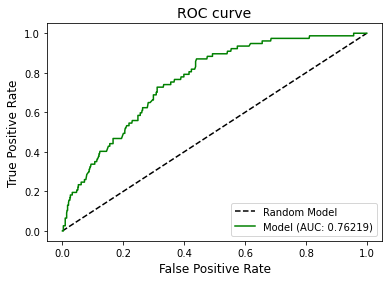

In [57]:
# Diagnosis Curva ROC
plot_auc_roc(Y,Y_pred)

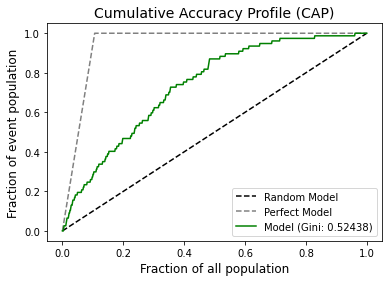

In [58]:
# Diagnosis Cumulative Accuracy Profile (CAP)

plot_cap(Y, Y_pred)

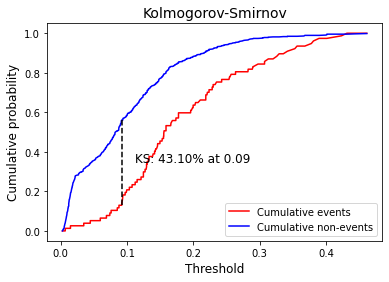

In [59]:
# Diagnosis  Plot Kolmogorov-Smirnov (KS)
plot_ks(Y, Y_pred)

In [60]:
Y_test_pred=tarjeta.predict_proba(X_test)[:,1]

# Calculamos la media
Y_test_pred.mean().round(5)

0.10698

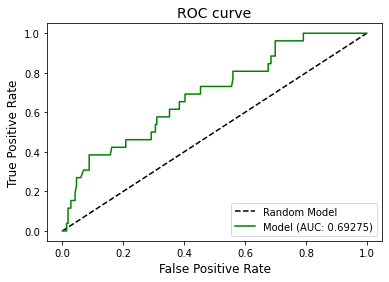

In [61]:
# Diagnosis Curva ROC
plot_auc_roc(Y_test,Y_test_pred)

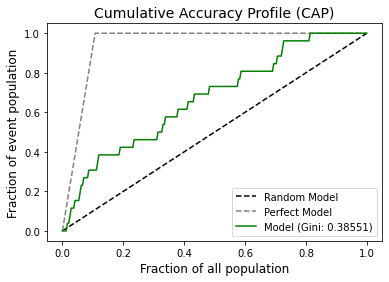

In [62]:
plot_cap(Y_test,Y_test_pred)

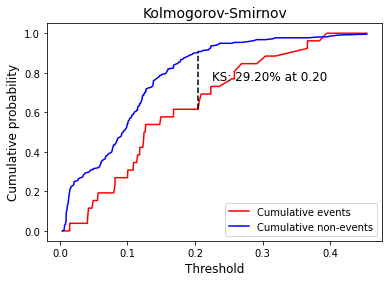

In [63]:
plot_ks(Y_test,Y_test_pred)

In [64]:
# Ahora vamos a calcular los score o puntuaciones.
#Que podemos hacer  con la función score
score = tarjeta.score(X)

print(score.min())
print(score.max())
print(score.mean())

# Transformación lineal según apuntes
# Factor= (pdo_0/log(2))
# Offset = scorecard_points_0+(pdo_0/log(2))*log(odds0_0)
# score= Offset - Factor *log(odds)

Factor= (pdo_0/np.log(2))
Offset = scorecard_points_0+Factor*np.log(1/odds_0_B)
score2= Offset-Factor*np.log(Y_pred/(1-Y_pred))

print(score2.min())
print(score2.max())
print(score2.mean())

datos_score=pd.DataFrame(np.transpose([score,score2, Y,Y_pred]), columns=['score','scoreManual','Y','Y_pred'])

# datos_score.to_excel("score_p1.xlsx")

383.21449191298854
722.2594687439909
526.0883808661948
383.2144919129886
722.2594687439909
526.0883808661948


In [65]:
Prob_Corte=Y.mean()
Score_Corte= Offset-Factor*np.log(Prob_Corte/(1-Prob_Corte))

print("La probabilida de corte de: ", Prob_Corte, " equivale a una puntuación de corte de: ", Score_Corte.round(2) )

La probabilida de corte de:  0.10606060606060606  equivale a una puntuación de corte de:  497.26


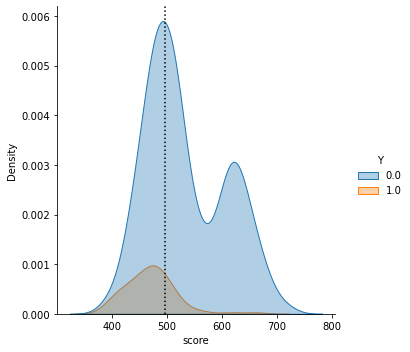

In [66]:
datos_score=pd.DataFrame(np.transpose([score,Y]), columns=['score','Y'])
sns.displot(data=datos_score, x='score', label="event", hue='Y', alpha=0.35,kind="kde", fill=True)
plt.axvline(Score_Corte, color='k', linestyle=":")

# Inferencia de Rechazados

In [67]:
# primero estimo el punto de corte utilizando el valor medio (calculo su f1-score)
from sklearn.metrics import f1_score
Prob_Corte=Y.mean()
print(Prob_Corte)
f1_score(Y,Y_pred>Y_pred.mean())

0.10606060606060606


0.30612244897959184

In [68]:
# Hacemos la inferencia
X_rechazados = rechazados.drop(columns=['default', 'Cardhldr', 'ID', 'Exp_Inc', 'Avgexp', 'Income', 'Inc_per']) #todas menos la variable y (que de hecho estaba vacía por que hay que estimarla)
Y_rechazados_pred=tarjeta.predict_proba(X_rechazados)[:,1]
rechazados["default"]=np.multiply(Y_rechazados_pred>Prob_Corte,1)


In [69]:
# Hago también una primera estimazión de la puntuación de los nuevos clientes para ver si hay diferencias con y sin rechazados
X_Nuevos = nuevos.drop(columns=['default', 'Cardhldr', 'ID', 'Exp_Inc', 'Avgexp', 'Income', 'Inc_per']) #todas menos la variable y (que de hecho estaba vacía por que hay que estimarla)
Y_Nuevos_pred=tarjeta.predict_proba(X_Nuevos)[:,1]
nuevos["y_Sinrechazados"]=np.multiply(Y_Nuevos_pred>Prob_Corte,1)

In [70]:
acep_rech =pd.concat([aceptados,rechazados], axis=0)

In [71]:
acep_rech.reset_index()

,index,ID,Cardhldr,default,Age,Income,Exp_Inc,Avgexp,Ownrent,Selfempl,Depndt,Inc_per,Cur_add,Major,Active,income_log
0,0,1.0,1.0,0,27.08333,2.4000,0.016798,33.01333,0,0,0.0,2.400000,56.0,1,1.0,0.875469
1,1,2.0,1.0,1,24.25000,3.5000,0.069963,203.89170,0,0,0.0,3.500000,60.0,1,11.0,1.252763
2,2,4.0,1.0,0,40.33333,3.0670,0.159700,408.08250,0,0,2.0,1.022333,18.0,0,0.0,1.120700
3,3,5.0,1.0,0,28.16667,3.3500,0.071625,199.36920,1,0,0.0,3.350000,18.0,1,2.0,1.208960
4,4,7.0,1.0,1,23.25000,1.8769,0.353630,553.10670,0,0,0.0,1.876900,12.0,1,3.0,0.629621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,286,1272.0,0.0,0,23.83333,2.5500,0.000471,0.00000,1,0,2.0,0.850000,24.0,1,0.0,0.936093
1255,287,1274.0,0.0,0,56.00000,1.4500,0.000828,0.00000,1,0,0.0,1.450000,242.0,1,4.0,0.371564
1256,288,1277.0,0.0,1,29.50000,3.0000,0.000400,0.00000,1,0,2.0,1.000000,60.0,1,8.0,1.098612
1257,289,1280.0,0.0,0,19.50000,1.5600,0.000769,0.00000,1,0,0.0,1.560000,46.0,0,3.0,0.444686


In [72]:
acep_rech.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1259 entries, 0 to 290
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          1259 non-null   float64
 1   Cardhldr    1259 non-null   float64
 2   default     1259 non-null   int64  
 3   Age         1259 non-null   float64
 4   Income      1259 non-null   float64
 5   Exp_Inc     1259 non-null   float64
 6   Avgexp      1259 non-null   float64
 7   Ownrent     1259 non-null   int64  
 8   Selfempl    1259 non-null   int64  
 9   Depndt      1259 non-null   float64
 10  Inc_per     1259 non-null   float64
 11  Cur_add     1259 non-null   float64
 12  Major       1259 non-null   int64  
 13  Active      1259 non-null   float64
 14  income_log  1259 non-null   float64
dtypes: float64(11), int64(4)
memory usage: 157.4 KB


In [73]:
acep_rech.default.value_counts(normalize=True)

0    0.838761
1    0.161239
Name: default, dtype: float64

In [74]:
### Dividimos la muestra en entrenamiento y test
acep_rech_train, acep_rech_test = train_test_split(acep_rech,stratify=acep_rech["default"], test_size=.25, random_state=1234)
acep_rech_train["default"].mean()
acep_rech_test["default"].mean()
### Defino la tramificación óptima

# 1) Definimos la lista de nombres señalando cuales de ellas son las categóricas
Y = acep_rech_train["default"].values
X = acep_rech_train.drop(columns=['default', 'Cardhldr', 'ID', 'Exp_Inc', 'Avgexp', 'Income', 'Inc_per']) #todas menos la variable y
list_variables = X.columns.values.tolist()
list_categorical = X.select_dtypes(include=['object', 'category']).columns.values.tolist()

# 2) Definimos el criterio de selección
selection_criteria = {
    "iv": {"min": 0.02, "max": 1}
}
# En caso de que desee modificarse los valores por defecto en el proceso de tramificación de alguna variable puede hacerse en forma de diccionario

binning_fit_params={
    "purpose":{"cat_cutoff": 0.10}
}

# 3) Definimos el proceso de Tramificación o BinningProcess
binning_process = BinningProcess(
    categorical_variables=list_categorical,
    variable_names=list_variables,
    selection_criteria=selection_criteria,
    binning_fit_params=binning_fit_params)

# 4) Obtenemos los tramos optimos de todas las Variables
dt_train_binned = binning_process.fit(X, Y)
dt_train_binned.summary().sort_values('iv')

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
5,Major,numerical,OPTIMAL,False,2,0.015864,0.001977,0.046186,0.02124
2,Selfempl,numerical,OPTIMAL,False,2,0.01694,0.0021,0.034024,0.009901
3,Depndt,numerical,OPTIMAL,True,4,0.038204,0.004763,0.099839,0.005878
1,Ownrent,numerical,OPTIMAL,True,2,0.041926,0.005231,0.102073,0.111854
7,income_log,numerical,OPTIMAL,True,5,0.226594,0.027602,0.253697,0.272609
4,Cur_add,numerical,OPTIMAL,True,6,0.39892,0.047335,0.325716,0.605195
0,Age,numerical,OPTIMAL,True,7,0.497931,0.057857,0.352339,0.100579
6,Active,numerical,OPTIMAL,False,6,1.255065,0.127319,0.492507,0.001481


In [75]:
# Directamente con el método Scorecard
estimator = LogisticRegression(solver="lbfgs")

# Establecemos los parámetros para la transformación de probabilidades en puntos de calidad crediticia o score

pdo_0 =40
scorecard_points_0= 600 
odds_0_B= 50 # (equivalente a  odds_0 =1/50 )

tarjeta= Scorecard(binning_process=binning_process,
                   estimator=estimator,
                   scaling_method="pdo_odds",
                   scaling_method_params={"pdo":pdo_0, "odds": odds_0_B, "scorecard_points": scorecard_points_0})

tarjeta.fit(X, Y, show_digits=4)

Scorecard(binning_process=BinningProcess(binning_fit_params={'purpose': {'cat_cutoff': 0.1}},
                                         categorical_variables=[],
                                         selection_criteria={'iv': {'max': 1,
                                                                    'min': 0.02}},
                                         variable_names=['Age', 'Ownrent',
                                                         'Selfempl', 'Depndt',
                                                         'Cur_add', 'Major',
                                                         'Active',
                                                         'income_log']),
          estimator=LogisticRegression(), scaling_method='pdo_odds',
          scaling_method_params={'odds': 50, 'pdo': 40,
                                 'scorecard_points': 600})

In [76]:
# obtenmos las predicciones
Y_pred=tarjeta.predict_proba(X)[:,1]

# Calculamos la media
Y_pred.mean().round(5)

0.16102

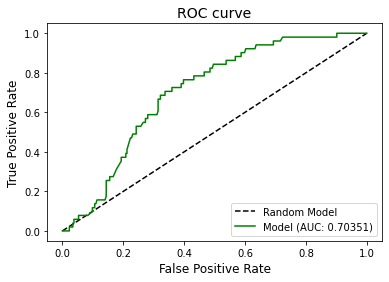

In [77]:
#### OJO que la diagnosis debe hacerse fuera de la muestra de entrenamiento
# obtenmos las predicciones
Y_test = acep_rech_test['default'].values
X_test = acep_rech_test.drop(columns=['default']) #todas menos la primera que es el ID y la variable y

Y_test_pred=tarjeta.predict_proba(X_test)[:,1]

# Diagnosis Curva ROC
plot_auc_roc(Y_test,Y_test_pred)


In [78]:
# primero estimo el punto de corte utilizando el valor medio (calculo su f1-score)
Prob_Corte=Y.mean()
print(Prob_Corte)
f1_score(Y,Y_pred>Y_pred.mean())
# Hacemos la inferencia

X_Nuevos = nuevos.drop(columns=['default']) #todas menos la variable y (que de hecho estaba vacía por que hay que estimarla)
Y_Nuevos_pred=tarjeta.predict_proba(X_Nuevos)[:,1]
nuevos["y_Conrechazados"]=np.multiply(Y_Nuevos_pred>Prob_Corte,1)

0.16101694915254236


In [79]:
nuevos_aceptados = nuevos.loc[nuevos.y_Conrechazados == 0]
nuevos_aceptados

,ID,Cardhldr,default,Age,Income,Exp_Inc,Avgexp,Ownrent,Selfempl,Depndt,Inc_per,Cur_add,Major,Active,income_log,y_Sinrechazados,y_Conrechazados
0,1286,NaN,NaN,27.00000,2.6750,0.034820,77.286670,1,0,0,2.675000,135,1,0,0.983949,0,0
1,1287,NaN,NaN,27.58333,5.5000,0.220473,1010.502000,0,1,0,5.500000,72,1,11,1.704748,0,0
2,1288,NaN,NaN,31.25000,5.0000,0.074378,309.910000,1,0,2,1.666667,12,1,12,1.609438,0,0
3,1289,NaN,NaN,25.25000,2.8800,0.041061,98.464160,0,0,0,2.880000,7,1,0,1.057790,0,0
4,1290,NaN,NaN,30.00000,1.8500,0.107582,165.855000,0,0,0,1.850000,60,1,12,0.615186,1,0
6,1292,NaN,NaN,33.25000,3.6000,0.025991,77.806660,0,0,3,0.900000,16,1,9,1.280934,1,0
11,1297,NaN,NaN,43.08333,2.4317,0.080526,163.180000,0,0,2,0.810567,18,1,28,0.888591,1,0
13,1299,NaN,NaN,26.50000,2.6000,0.110648,239.486700,1,0,0,2.600000,12,1,13,0.955511,0,0
17,1303,NaN,NaN,23.50000,2.8000,0.003929,8.333333,1,0,0,2.800000,12,1,3,1.029619,0,0
19,1305,NaN,NaN,26.16667,4.0000,0.001200,3.166667,0,0,2,1.333333,18,0,0,1.386294,0,0
